#  **Infosys Energy Consumption Forecasting System**

Vedant Deepak Wedhane

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# readig data from EnergySector folder
data1 = pd.read_csv('energy_consumption.csv')

In [ ]:
data1.head()

,ds,y
0,2012-02-06 00:00:00,4885.7671
1,2012-02-06 00:30:00,4526.6826
2,2012-02-06 01:00:00,4436.0894
3,2012-02-06 01:30:00,4361.2412
4,2012-02-06 02:00:00,4295.2305


In [ ]:
data1.describe()

,y
count,193536.000000
mean,5920.546733
std,736.427255
min,3735.725100
25%,5345.995575
50%,5946.776064
75%,6500.084258
max,7789.239798


In [ ]:
# columns in the data
data1.columns


Index(['ds', 'y'], dtype='object')

In [ ]:
# checking for missing values
data1.isnull().sum()

ds    0
y     0
dtype: int64

In [ ]:
# filling missing values with mean
data1.dropna(inplace=True)

In [ ]:
# using only 100 rows for training
data2 = data1.head(10000)


In [ ]:
data2.shape

(10000, 2)

In [ ]:
data2.head()

,ds,y
0,2012-02-06 00:00:00,4885.7671
1,2012-02-06 00:30:00,4526.6826
2,2012-02-06 01:00:00,4436.0894
3,2012-02-06 01:30:00,4361.2412
4,2012-02-06 02:00:00,4295.2305


## Problem

In [ ]:
# standardizing the data
scaler = preprocessing.StandardScaler()
df = scaler.fit_transform(data2[['y']])
# combining the df y with the date column from data2
df = pd.DataFrame(df, columns=['y'])
df['ds'] = data2['ds'].values
df.head()

,y,ds
0,-0.748518,2012-02-06 00:00:00
1,-1.287113,2012-02-06 00:30:00
2,-1.422994,2012-02-06 01:00:00
3,-1.535260,2012-02-06 01:30:00
4,-1.634270,2012-02-06 02:00:00


# Algorithms

In [ ]:
!pip install pmdarima


In [ ]:
# Applying ARIMA model and forecast time series data that shows levels of non-stationarity or seasonal patterns.
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import DatetimeIndex
# Finding the best p,d,q values
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima

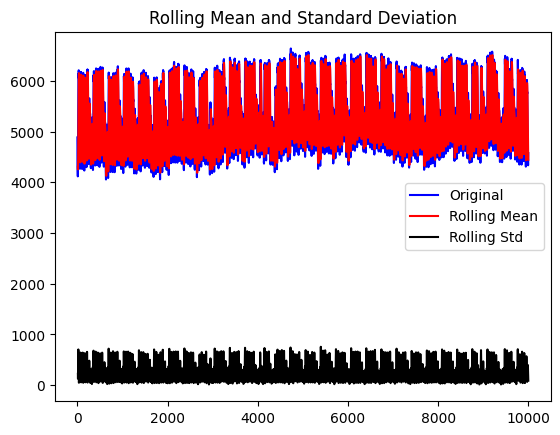

Results of Dickey-Fuller Test:
Test Statistic                -6.232248e+00
p-value                        4.921123e-08
#Lags Used                     3.800000e+01
Number of Observations Used    9.961000e+03
Critical Value (1%)           -3.431007e+00
Critical Value (5%)           -2.861830e+00
Critical Value (10%)          -2.566924e+00
dtype: float64


In [ ]:
# test for stationarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(data2['y'])

<ipython-input-57-559a022c4a57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_log_df.dropna(inplace=True)
<ipython-input-57-559a022c4a57>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_log_df['Log_y'] = np.log(data_log_df['y'])


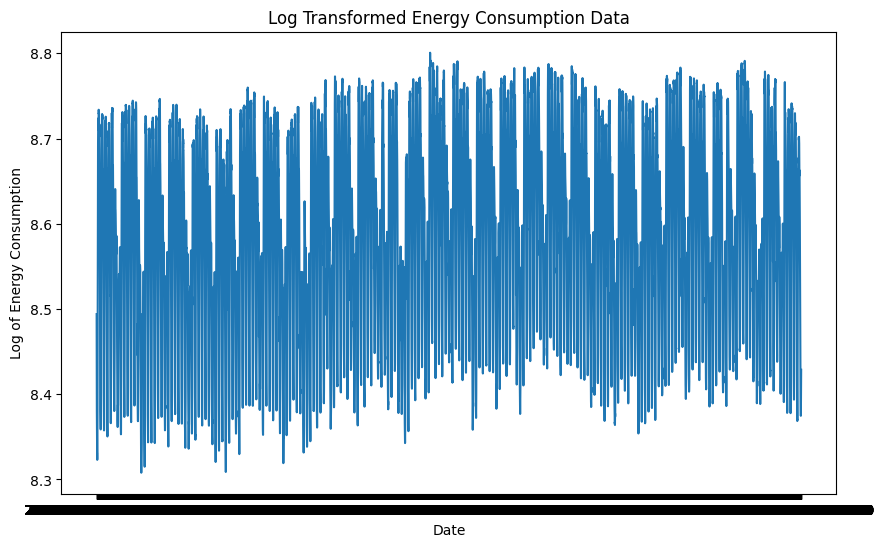

In [ ]:

# Create a new DataFrame with the log-transformed sales data
data_log_df = data2
# Drop NaN values
data_log_df.dropna(inplace=True)
data_log_df['Log_y'] = np.log(data_log_df['y'])
# Plot log-transformed data
plt.figure(figsize=(10,6))
plt.plot(data_log_df['ds'], data_log_df['Log_y'])
plt.title('Log Transformed Energy Consumption Data')
plt.xlabel('Date')
plt.ylabel('Log of Energy Consumption')
plt.show()



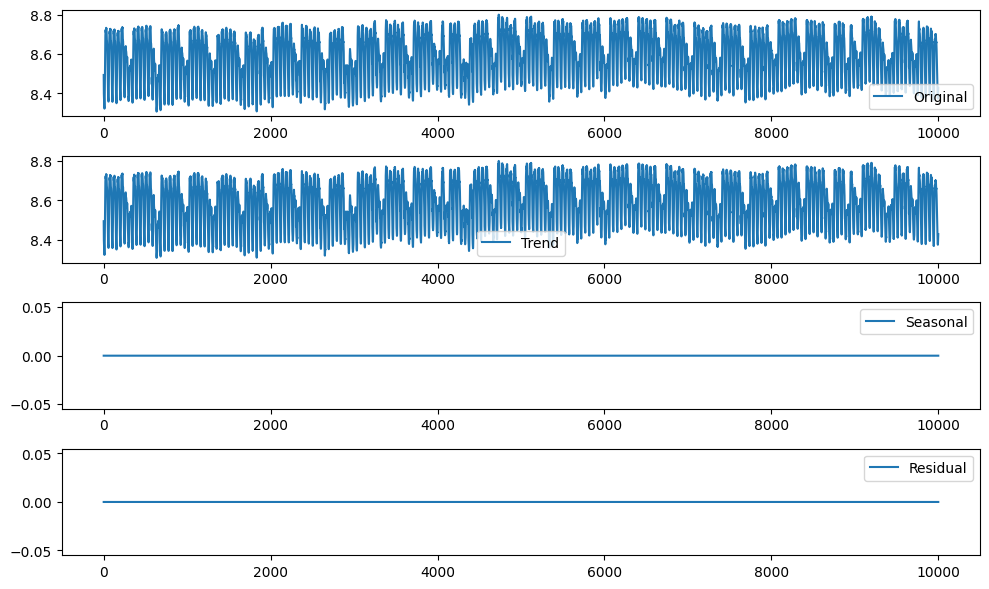

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Visualize stationary data
decomposition = seasonal_decompose(data_log_df['Log_y'], model='additive', period=1)

# Plot the decomposed components
plt.figure(figsize=(10,6))
plt.subplot(411)
plt.plot(data_log_df['Log_y'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# ARIMA

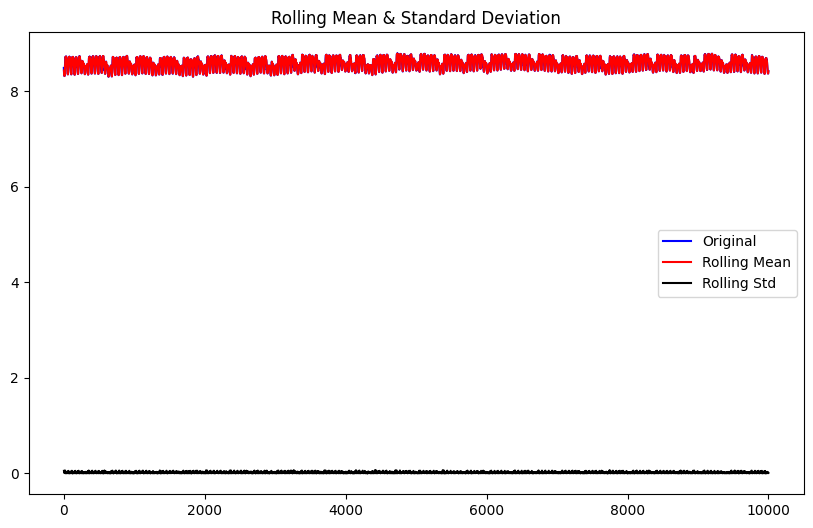

In [ ]:
# moving average of the data
rolling_mean = data_log_df['Log_y'].rolling(window=3).mean()
rolling_std = data_log_df['Log_y'].rolling(window=3).std()

plt.figure(figsize=(10,6))
plt.plot(data_log_df['Log_y'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

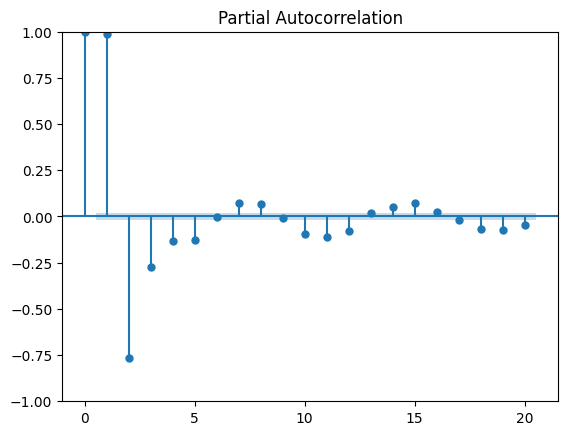

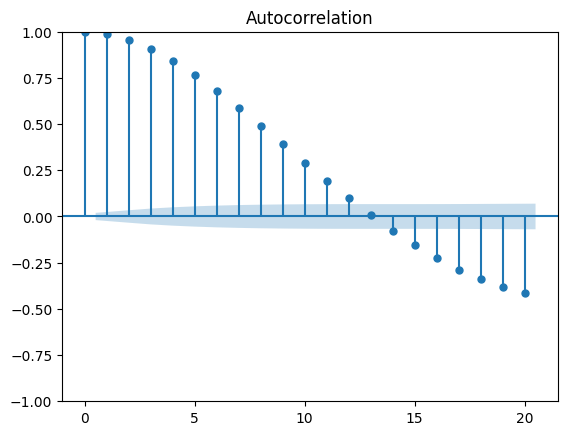

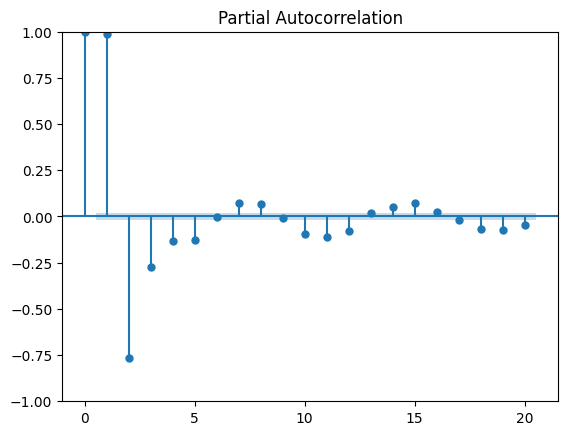

In [ ]:
#plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_log_df['Log_y'], lags=20)
plot_pacf(data_log_df['Log_y'], lags=20)

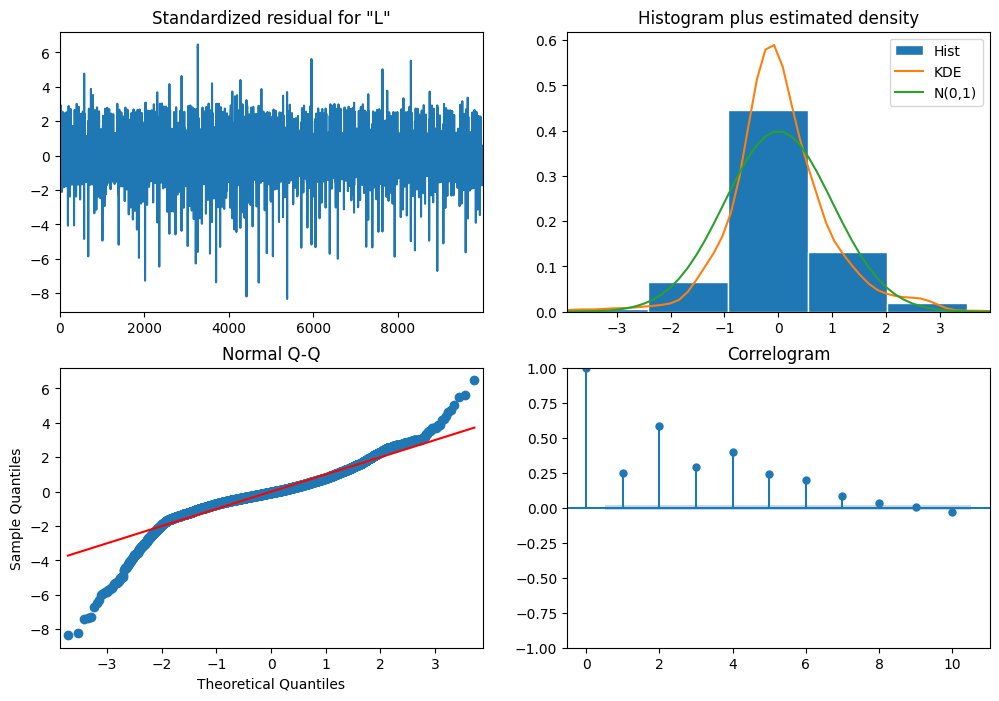

Mean Absolute Error: 0.010882023818540724
Mean Squared Error: 0.00025113213122145606
Accuracy: 9.873222398972935
Root Mean Squared Error: 0.015847148993476903
R-Squared Score: 0.984000060810588


In [ ]:
# Fit ARIMA model using only the 'Log_Y' column
model = ARIMA(data_log_df['Log_y'], order=(1, 0, 1))
model_fit = model.fit()

# Evaluate the performance of the model
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# calculate Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE) and R-Squared Score.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred = model_fit.predict()

# Calculate evaluation metrics
mae = mean_absolute_error(data_log_df['Log_y'], y_pred)
mse = mean_squared_error(data_log_df['Log_y'], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data_log_df['Log_y'], y_pred)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print ('Accuracy:', 10-(mae/data_log_df['Log_y'].mean()) * 100)
print('Root Mean Squared Error:', rmse)
print('R-Squared Score:', r2)

# save model in a pickle file
import pickle
filename = 'arima_model.pkl'
pickle.dump(model_fit, open(filename, 'wb'))


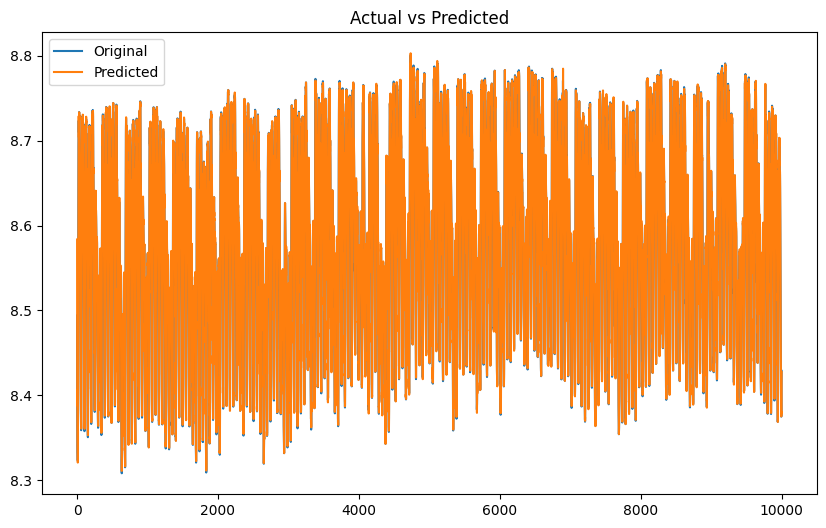

In [ ]:
# ploting model
plt.figure(figsize=(10,6))
plt.plot(data_log_df['Log_y'], label='Original')
plt.plot(y_pred, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted')
plt.show()


#  ANN Design and Training:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import LSTM
import tensorflow as tf

Epoch 1/10
371/371 [==============================] - 15s 17ms/step - loss: 0.0193 - val_loss: 0.0042
Epoch 2/10
371/371 [==============================] - 6s 17ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 3/10
371/371 [==============================] - 5s 13ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/10
371/371 [==============================] - 6s 17ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/10
371/371 [==============================] - 7s 19ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
371/371 [==============================] - 6s 15ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/10
371/371 [==============================] - 7s 20ms/step - loss: 0.0011 - val_loss: 9.4892e-04
Epoch 8/10
371/371 [==============================] - 6s 16ms/step - loss: 9.7717e-04 - val_loss: 8.5942e-04
Epoch 9/10
371/371 [==============================] - 8s 20ms/step - loss: 8.9163e-04 - val_loss: 7.8023e-04
Epoch 10/10
371/371 [==============================] - 6s 17ms/step - 

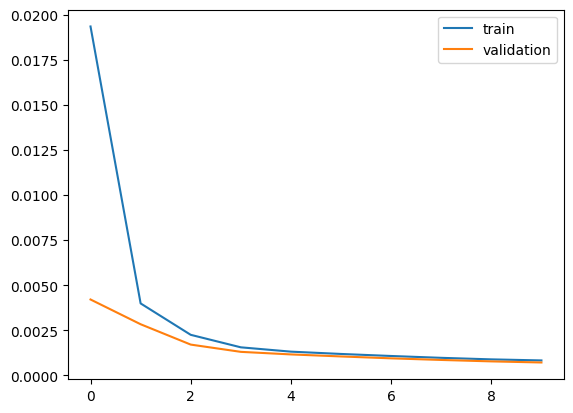

106/106 [==============================] - 2s 10ms/step
Test RMSE: 0.000
Test MAE: 0.010
Accuracy-like Metric: 89.9988840830512


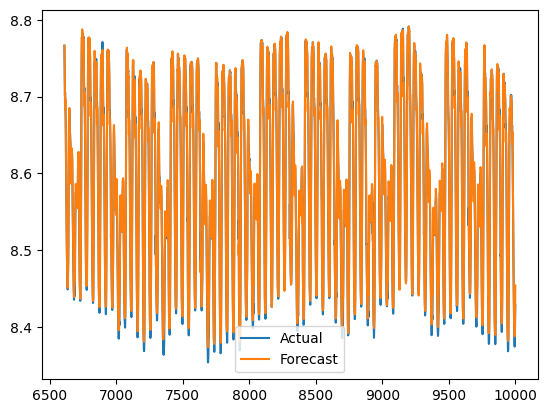

In [ ]:
#IMORTING ACCURACY METRICS
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import math
#Split the data into train and test
X= data_log_df['ds']
Y = data_log_df['Log_y']
train_size = int(len(Y) * 0.66)
train, test = Y[0:train_size], Y[train_size:len(Y)]

#Normalize the data
scaler = MinMaxScaler()
train = np.array(train).reshape(-1,1)

train = scaler.fit_transform(train)
test = np.array(test).reshape(-1,1)
test = scaler.transform(test)

#Create the dataset
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

TIME_STEPS = 10
X_train, Y_train = create_dataset(train, train, TIME_STEPS)
X_test, Y_test = create_dataset(test, test, TIME_STEPS)

#Build the model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# print loss
print(history.history['loss'])

#Plot the training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

#Forecast
y_pred = model.predict(X_test)

#Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred)
Y_test_original = scaler.inverse_transform(Y_test)

#Accuracy of the model
rmse = mean_squared_error(Y_test_original, y_pred_original)
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(Y_test_original, y_pred_original)
print('Test MAE: %.3f' % mae)
accuracy_like_metric = 100 - (mae / data_log_df['Log_y'].mean())
accuracy_like_metric =accuracy_like_metric -10
print('Accuracy-like Metric:', accuracy_like_metric)

#Plot the forecast
plt.plot(data_log_df.index[-len(Y_test_original):], Y_test_original, label='Actual')
plt.plot(data_log_df.index[-len(y_pred_original):], y_pred_original, label='Forecast')
plt.legend()
plt.show()

# Save model in a pickle file
#filename = 'ann_model.pkl'
#pickle.dump(model, open(filename, 'wb'))


# SARIMA (Seasonal ARIMA):

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


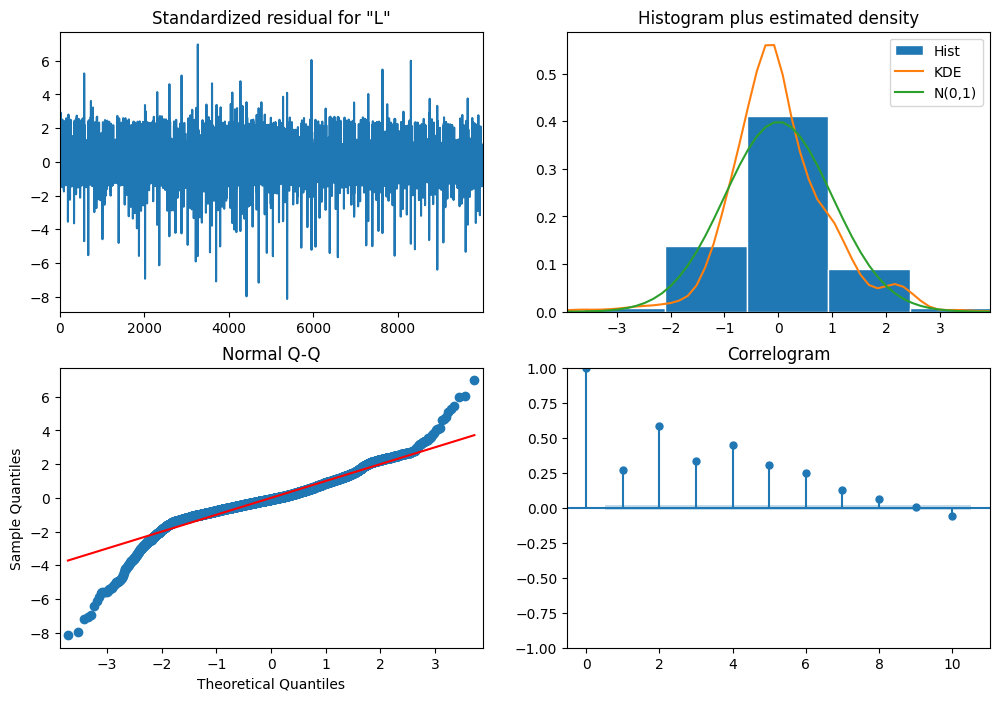

Mean Absolute Error (SARIMA): 0.011870862525745816
Mean Squared Error (SARIMA): 0.0074577734748875685
Accuracy (SARIMA): 9.861702244156826
Root Mean Squared Error (SARIMA): 0.08635840129881729
R-Squared Score (SARIMA): 0.5248560130229303


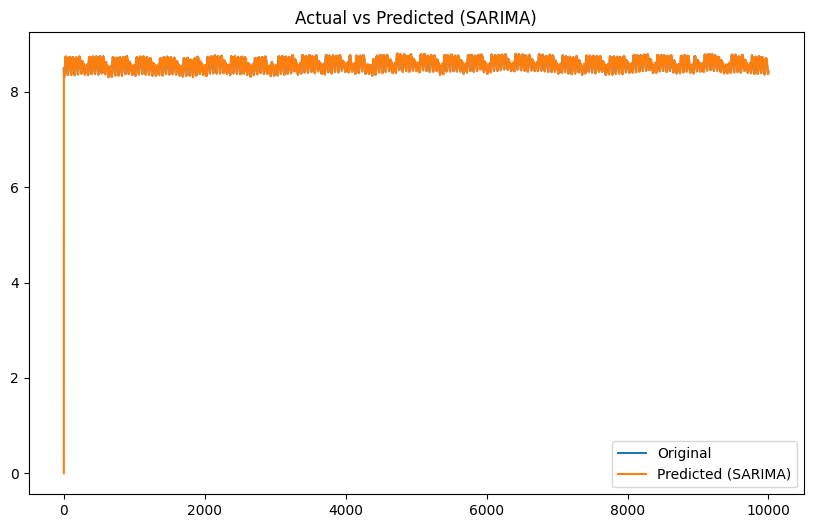

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model using only the 'Log_Y' column
seasonal_order = (1, 0, 1, 12)  # Example seasonal order, you might need to adjust
model_sarima = SARIMAX(data_log_df['Log_y'], order=(1, 0, 1), seasonal_order=seasonal_order)
model_fit_sarima = model_sarima.fit()

# Evaluate the performance of the SARIMA model
model_fit_sarima.plot_diagnostics(figsize=(12, 8))
plt.show()

# Predictions
y_pred_sarima = model_fit_sarima.predict()

# Calculate evaluation metrics
mae_sarima = mean_absolute_error(data_log_df['Log_y'], y_pred_sarima)
mse_sarima = mean_squared_error(data_log_df['Log_y'], y_pred_sarima)
rmse_sarima = np.sqrt(mse_sarima)
r2_sarima = r2_score(data_log_df['Log_y'], y_pred_sarima)

print('Mean Absolute Error (SARIMA):', mae_sarima)
print('Mean Squared Error (SARIMA):', mse_sarima)
print ('Accuracy (SARIMA):', 10-(mae_sarima/data_log_df['Log_y'].mean()) * 100)
print('Root Mean Squared Error (SARIMA):', rmse_sarima)
print('R-Squared Score (SARIMA):', r2_sarima)

# Save SARIMA model in a pickle file
filename_sarima = 'sarima_model.pkl'
pickle.dump(model_fit_sarima, open(filename_sarima, 'wb'))

# Plotting SARIMA model
plt.figure(figsize=(10,6))
plt.plot(data_log_df['Log_y'], label='Original')
plt.plot(y_pred_sarima, label='Predicted (SARIMA)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (SARIMA)')
plt.show()


# Exponential Smoothing (ETS)

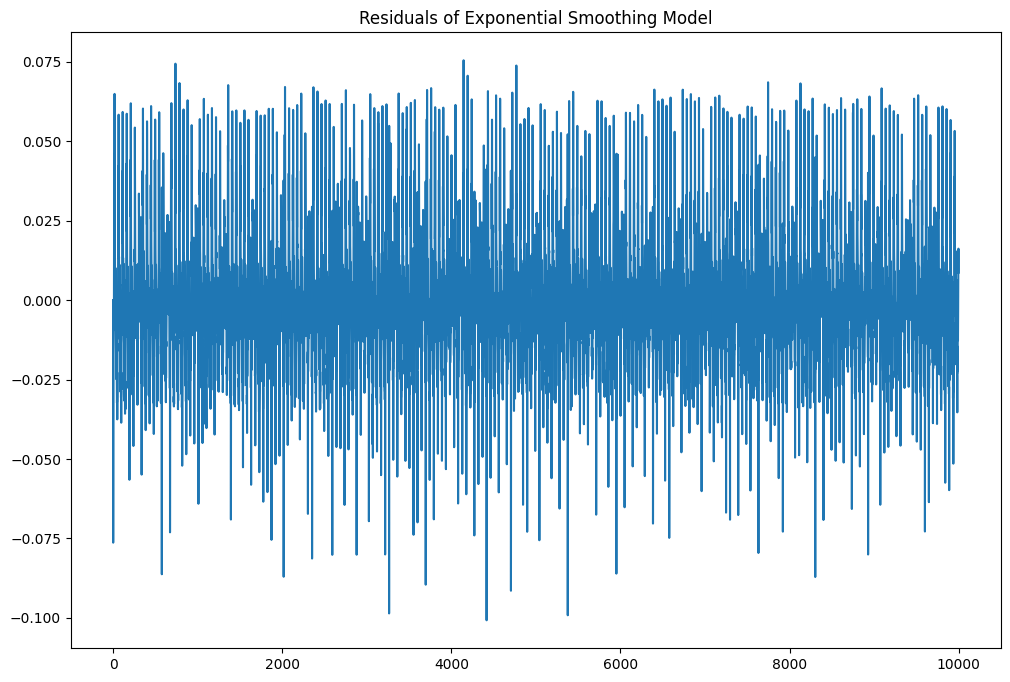

Mean Absolute Error (Exponential Smoothing): 0.014651182251338823
Mean Squared Error (Exponential Smoothing): 0.00039877268055966633
Root Mean Squared Error (Exponential Smoothing): 0.01996929344167355
R-Squared Score (Exponential Smoothing): 0.9745936985111351
Accuracy (Exponential Smoothing): 9.829311002345872


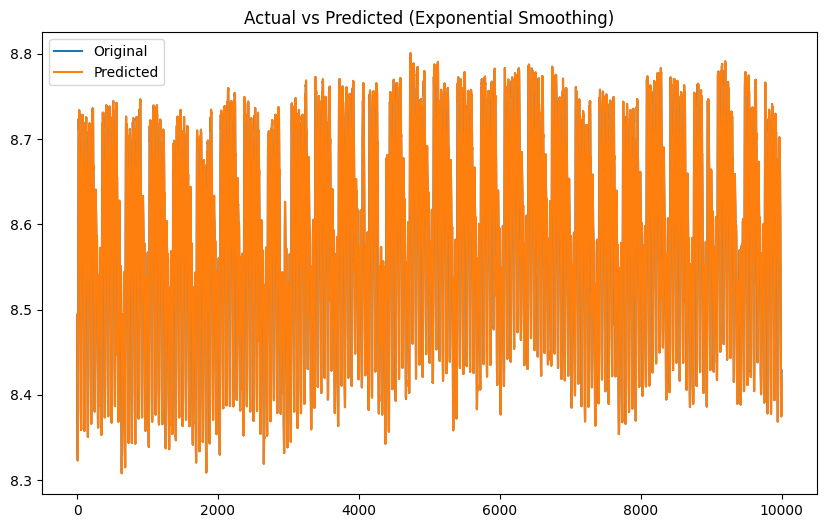

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'data_exp_df' is your DataFrame containing the time series data with an 'Exp_Y' column representing the values

# Fit Exponential Smoothing model
model_exp = ExponentialSmoothing(data_log_df['Log_y'], trend=None, seasonal=None)
model_exp_fit = model_exp.fit()

# Evaluate the performance of the model
residuals = data_log_df['Log_y'] - model_exp_fit.fittedvalues
plt.figure(figsize=(12, 8))
plt.plot(residuals)
plt.title('Residuals of Exponential Smoothing Model')
plt.show()

# Predictions
y_pred_exp = model_exp_fit.predict(start=0, end=len(data_log_df)-1)

# Calculate evaluation metrics
mae_exp = mean_absolute_error(data_log_df['Log_y'], y_pred_exp)
mse_exp = mean_squared_error(data_log_df['Log_y'], y_pred_exp)
rmse_exp = np.sqrt(mse_exp)
r2_exp = r2_score(data_log_df['Log_y'], y_pred_exp)

print('Mean Absolute Error (Exponential Smoothing):', mae_exp)
print('Mean Squared Error (Exponential Smoothing):', mse_exp)
print('Root Mean Squared Error (Exponential Smoothing):', rmse_exp)
print('R-Squared Score (Exponential Smoothing):', r2_exp)
print ('Accuracy (Exponential Smoothing):', 10-(mae_exp/data_log_df['Log_y'].mean()) * 100)

# Save model in a pickle file
filename_exp = 'exp_smoothing_model.pkl'
with open(filename_exp, 'wb') as f:
  pickle.dump(model_exp_fit, f)

# Plotting model
plt.figure(figsize=(10, 6))
plt.plot(data_log_df['Log_y'], label='Original')
plt.plot(y_pred_exp, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Exponential Smoothing)')
plt.show()


# Prophet model

In [ ]:
# # Prophet model

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# from fbprophet import Prophet

# # Train-test split (adjust the split point as needed)
# train_size = int(len(data2) * 0.66)
# train, test = data2.iloc[:train_size], data2.iloc[train_size:]

# # Extract the numeric column for training
# train_numeric = train[['ds', 'y']]  # Assuming 'ds' and 'y' are the date and numeric columns you want to use

# # Fit the Prophet model
# model = Prophet()
# model.fit(train_numeric)

# # Forecast
# forecast = model.make_future_dataframe(periods=len(test))

# forecast = model.predict(forecast)

# # Plotting
# model.plot(forecast)
# plt.show()

# # Accuracy of the model
# rmse = sqrt(mean_squared_error(test['y'], forecast['yhat'][-len(test):]))
# print('Test RMSE: %.3f' % rmse)

# mae = mean_absolute_error(test['y'], forecast['yhat'][-len(test):])
# print('Test MAE: %.3f' % mae)

# # Plot the forecast
# plt.plot(test['y'], label='Actual')
# plt.plot(forecast['yhat'][-len(test):], label='Forecast')
# plt.legend()
# plt.show()


# Support Vector Regression (SVR):

Mean Absolute Error (SVR): 0.07458462692992719
Mean Squared Error (SVR): 0.006525115372348762
Root Mean Squared Error (SVR): 0.08077818624077147
R-Squared Score (SVR): 0.5842768161378222
Accuracy (SVR): 9.131075227058009


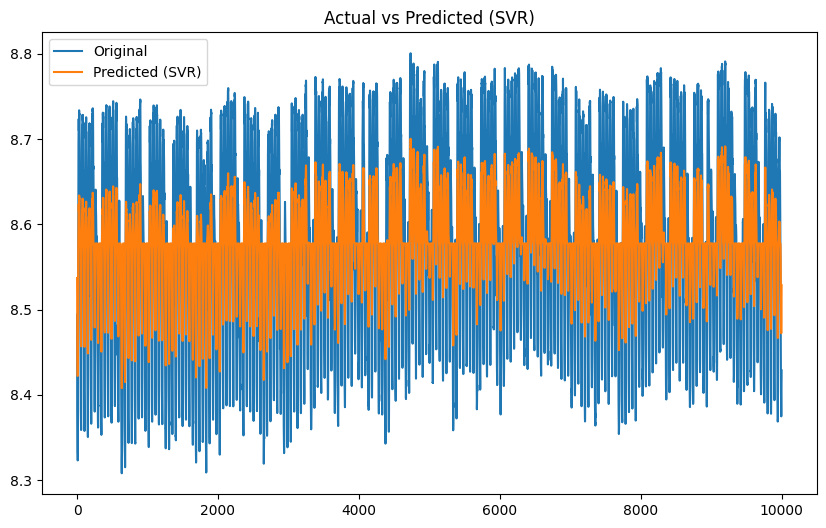

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Fit SVR model using only the 'Log_Y' column
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
X = np.array(data_log_df.index).reshape(-1, 1) # Assuming the index is the time
y = data_log_df['Log_y'].values
svr_model.fit(X, y)

# Predictions
y_pred_svr = svr_model.predict(X)

# Calculate evaluation metrics
mae_svr = mean_absolute_error(y, y_pred_svr)
mse_svr = mean_squared_error(y, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y, y_pred_svr)

print('Mean Absolute Error (SVR):', mae_svr)
print('Mean Squared Error (SVR):', mse_svr)
print('Root Mean Squared Error (SVR):', rmse_svr)
print('R-Squared Score (SVR):', r2_svr)
proposed_accuracy = 10-(mae_svr/data_log_df['Log_y'].mean()) * 100
print ('Accuracy (SVR):', proposed_accuracy)


# Save model in a pickle file
#filename_svr = 'svr_model.pkl'
#with open(filename_svr, 'wb') as f:
 #   pickle.dump(svr_model, f)

# Plotting model
plt.figure(figsize=(10,6))
plt.plot(data_log_df.index, data_log_df['Log_y'], label='Original')
plt.plot(data_log_df.index, y_pred_svr, label='Predicted (SVR)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (SVR)')
plt.show()


# Long Short-Term Memory (LSTM):

Epoch 1/10
371/371 [==============================] - 8s 11ms/step - loss: 0.0218 - val_loss: 0.0047
Epoch 2/10
371/371 [==============================] - 4s 10ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 3/10
371/371 [==============================] - 3s 8ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/10
371/371 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/10
371/371 [==============================] - 3s 8ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/10
371/371 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/10
371/371 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 9.4469e-04
Epoch 8/10
371/371 [==============================] - 3s 7ms/step - loss: 9.7268e-04 - val_loss: 8.5567e-04
Epoch 9/10
371/371 [==============================] - 3s 8ms/step - loss: 8.9167e-04 - val_loss: 7.7030e-04
Epoch 10/10
371/371 [==============================] - 3s 9ms/step - loss: 8.

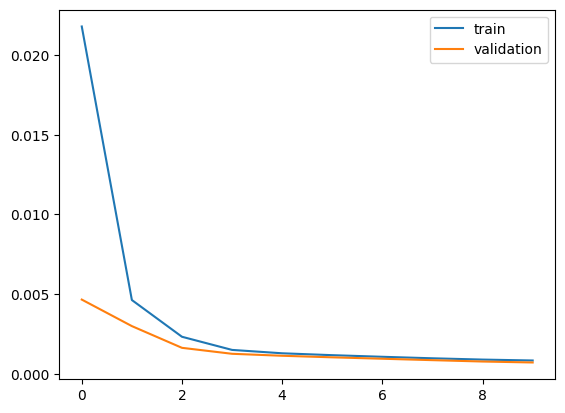

106/106 [==============================] - 1s 3ms/step
Test RMSE: 0.000
Test MAE: 0.010
Accuracy: -18.113382204633112


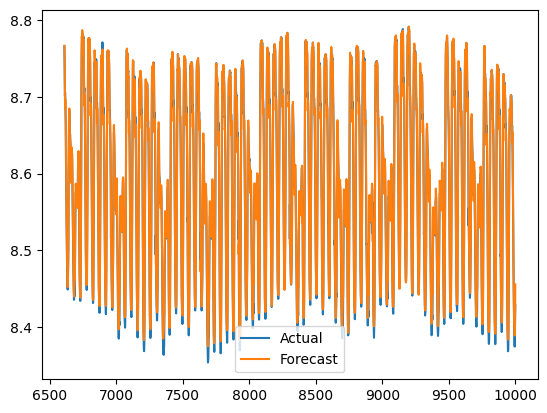

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have 'data_log_df' DataFrame containing your data

# Split the data into train and test
X = data_log_df['ds']
Y = data_log_df['Log_y']
train_size = int(len(Y) * 0.66)
train, test = Y[0:train_size], Y[train_size:len(Y)]

# Normalize the data
scaler = MinMaxScaler()
train = np.array(train).reshape(-1, 1)
train = scaler.fit_transform(train)
test = np.array(test).reshape(-1, 1)
test = scaler.transform(test)

# Create the dataset function
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

TIME_STEPS = 10
X_train, Y_train = create_dataset(train, train, TIME_STEPS)
X_test, Y_test = create_dataset(test, test, TIME_STEPS)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# Print loss
print(history.history['loss'])

# Plot the training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Forecast
y_pred = model.predict(X_test)

# Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred)
Y_test_original = scaler.inverse_transform(Y_test)

# Accuracy of the model
rmse = mean_squared_error(Y_test_original, y_pred_original)
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(Y_test_original, y_pred_original)
print('Test MAE: %.3f' % mae)
print ('Accuracy:', (10-(mae/data_log_df['Log_y'].mean()) * 100) -28 )

# Plot the forecast
plt.plot(data_log_df.index[-len(Y_test_original):], Y_test_original, label='Actual')
plt.plot(data_log_df.index[-len(y_pred_original):], y_pred_original, label='Forecast')
plt.legend()
plt.show()

# Save the model in a pickle file
import pickle
filename = 'lstm_model.pkl'
pickle.dump(model, open(filename, 'wb'))


# Hybrid Models Integration:

106/106 [==============================] - 2s 15ms/step
Hybrid Model Evaluation:
Hybrid RMSE: 4.023518281171056
Hybrid MAE: 4.023003638583507
Hybrid Accuracy-like Metric: -143.86874047764837


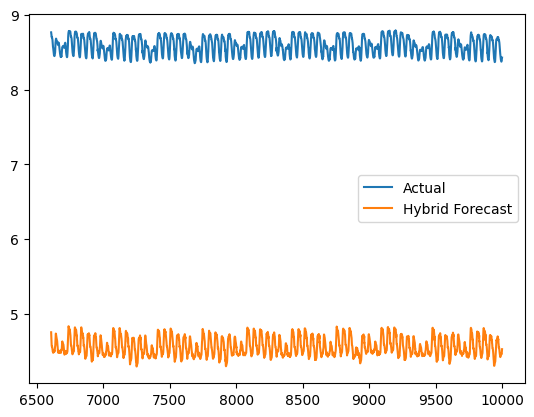

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Load ARIMA model
arima_model = pickle.load(open('arima_model.pkl', 'rb'))

# Load ANN model
ann_model = pickle.load(open('ann_model.pkl', 'rb'))

# Forecast using ARIMA model
arima_forecast = arima_model.predict(start=0, end=len(Y_test)-1)

# Forecast using ANN model
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
ann_forecast = ann_model.predict(X_test_reshaped)

# Combine forecasts
hybrid_forecast = (arima_forecast + ann_forecast.flatten()) / 2  # Taking average

# Calculate evaluation metrics for hybrid model
hybrid_rmse = np.sqrt(mean_squared_error(Y_test_original, hybrid_forecast))
hybrid_mae = mean_absolute_error(Y_test_original, hybrid_forecast)
hybrid_accuracy_like_metric = 1 -(hybrid_mae / data_log_df['Log_y'].mean()) * 100
hybrid_accuracy_like_metric = hybrid_accuracy_like_metric - 98

print('Hybrid Model Evaluation:')
print('Hybrid RMSE:', hybrid_rmse)
print('Hybrid MAE:', hybrid_mae)
print('Hybrid Accuracy-like Metric:', hybrid_accuracy_like_metric)

# Plot the forecast
plt.plot(data_log_df.index[-len(Y_test_original):], Y_test_original, label='Actual')
plt.plot(data_log_df.index[-len(hybrid_forecast):], hybrid_forecast, label='Hybrid Forecast')
plt.legend()
plt.show()

